## Epoxy case

In [28]:
def get_errors(surrogate, feats_train, target_train, feats_test, target_test):
    """
    Compute the training and test errors.

    Parameters
    ----------
    feats_train : array, shape (n_train, n_inputs)
        The training features.
    target_train : array, shape (n_train, n_outputs)
        The training target data points.
    feats_test : array (n_test, n_inputs)
        The test features.
    target_test : array, shape (n_test, n_outputs)
        The test target data points.

    Returns
    -------
    err_train : float
        The relative training error.
    err_test : float
        The relatiove test error.

    """

    train_pred = np.zeros([target_train.shape[0], target_train.shape[1]])
    for i in range(target_train.shape[0]):
        train_pred[i, :] = surrogate.predict(feats_train[i])

    err_train = np.mean(np.linalg.norm(target_train - train_pred, axis=0) /
                        np.linalg.norm(target_train, axis=0), axis=0)
    print("Relative training error = %.4f %%" % (err_train * 100))

    # run the trained model forward at test locations
    test_pred = np.zeros([target_test.shape[0], target_test.shape[1]])
    for i in range(target_test.shape[0]):
        test_pred[i] = surrogate.predict(feats_test[i])

    err_test = np.mean(np.linalg.norm(target_test - test_pred, axis=0) /
                       np.linalg.norm(target_test, axis=0), axis=0)
    print("Relative test error = %.4f %%" % (err_test * 100))

    return err_train, err_test

In [29]:
def plot_errors(results):
    """
    Plots the training and test error vs the number of epochs
    """
    epoch_stop = results['epoch_stop']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_ylabel('relative error', fontsize=14)
    for idx, err in enumerate(results['errors']):
        ax.plot(err[0:epoch_stop[idx], 0], '-o', label='training error', color = 'dodgerblue')
        ax.plot(err[0:epoch_stop[idx], 1], '-s', label='test error', color = 'salmon')
    ax.set_xticks(np.arange(n_epochs_max))
    handles, labels = ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.tight_layout()

In [30]:
def early_stopping(surrogate, n_epochs_max, n_iter, patience, min_delta):
    """
    Stop training when the test error has stopped improving.


    Parameters
    ----------
    surrogate : easysurrogate.methods
        An easySurrogate neural network.
    n_epochs_max : int
        The maximum number of epochs.
    n_iter : int
        The number mini-batch iterations per epoch.
    patience : int
        Number of epochs with no improvement after which training will be stopped.
    min_delta : int
        Minimum change in the test error to qualify as an improvement.

    Returns
    -------
    errors : array, shape (n_epochs_max, 2)
        Array containing the training and test errors.
    epoch : int
        The epoch at which training was stopped.

    """

    # store training and test errors
    errors = np.zeros([n_epochs_max, 2])

    # improvement is defined as a redution in testing error > min_delta
    improvement = np.zeros(n_epochs_max)

    # compute training & testing error 1st epoch
    errors[0] = get_errors(surrogate, params_train, samples_train, params_test, samples_test)
    improvement[0] = 1.

    # set the training flag to True in any layer that uses batch normalization
    surrogate.neural_net.set_batch_norm_training_flag(True)
    
    # retrain 
    for epoch in range(1, n_epochs_max):
        surrogate.neural_net.train(n_iter, store_loss = True)

        # compute training & testing error
        errors[epoch] = get_errors(surrogate, params_train, samples_train, params_test, samples_test)
        
        # check for improvement in test error
        improvement[epoch] = errors[epoch - 1, 1] - errors[epoch, 1] >= min_delta

        # stop if patience is exceeded
        if epoch >= patience:
            
            # exceeded patience: no improvent over the last patience epochs
            stop = np.array_equal(improvement[epoch - patience: epoch], np.zeros(patience))

            if stop:
                return errors, epoch

    # set the training flag to False in any layer that uses batch normalization
    surrogate.neural_net.set_batch_norm_training_flag(False)
            
    return errors, epoch

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import easysurrogate as es
from scipy import linalg, stats
import pandas as pd
import seaborn as sns
import easyvvuq as uq
import json

In [32]:
%matplotlib inline
plt.rcParams['image.cmap'] = 'seismic'
plt.rcParams['savefig.dpi'] = 300

### Install EasySurrogate

In [33]:
!pip install easysurrogate==0.24.1

### EasySurrogate campaign

EasySurrogate's basic object is called a `campaign', which handles the data. 

In [34]:
# Create EasySurrogate campaign
campaign = es.Campaign()

### Load prior ranges



In [35]:
# Load the EasyVVUQ params dict
priors = json.load(open('./epoxy.params.json', 'r'))
priors

{'p11': {'type': 'float', 'default': 0.01},
 'p12': {'type': 'float', 'default': 3.0},
 'p21': {'type': 'float', 'default': 0.015},
 'p22': {'type': 'float', 'default': 2.5},
 'p31': {'type': 'float', 'default': 0.03},
 'p32': {'type': 'float', 'default': 2.42},
 'p41': {'type': 'float', 'default': 0.03},
 'p42': {'type': 'float', 'default': 2.5},
 'p51': {'type': 'float', 'default': 0.066},
 'p52': {'type': 'float', 'default': 3.5},
 'p61': {'type': 'float', 'default': 0.07},
 'p62': {'type': 'float', 'default': 3.55},
 'p71': {'type': 'float', 'default': 0.14},
 'p72': {'type': 'float', 'default': 2.9},
 'p81': {'type': 'float', 'default': 0.17},
 'p82': {'type': 'float', 'default': 3.12},
 'p91': {'type': 'float', 'default': 0.17},
 'p92': {'type': 'float', 'default': 3.3},
 'b11': {'type': 'float', 'default': 268.0},
 'b12': {'type': 'float', 'default': 1.5290000000000001},
 'b21': {'type': 'float', 'default': 317.0},
 'b22': {'type': 'float', 'default': 1.51},
 'b31': {'type': 'fl

### Load input parameter values

In [36]:
# input parameters
params = pd.read_csv('./data_epoxy/epoxy_inputs.csv')
param_names = params.keys()
params = params.values

n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

# scale inputs within [-1, 1]
p_max = np.array([priors[name]['default'] * 1.15 for name in param_names])
p_min = np.array([priors[name]['default'] * 0.85 for name in param_names])
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

### Load output samples

In [37]:
# Output QoI
QoI = 'E11'
# QoI = 'poisson'

output = pd.read_csv('./data_epoxy/epoxy_%s_output.csv' % (QoI,)).values

### Average over the random seeds (or not)

In [38]:
# average the data over the replica simulations or not
average_over_replicas = True


if not average_over_replicas:
    samples = output[:, 0].reshape([-1, 1])
else:
    samples = np.mean(output, axis=1, keepdims=True)

### Select $d$

This is the dimension of the active subspace.

In [39]:
d = 1

###  Set hyperparameters

In [40]:
# number of neurons per hidden layer 
n_hidden_neurons = 10
# number of hidden layer + output layer
n_layers = 3
# activation function
activation = 'tanh'

# mini batch size
batch_size = 32
# max number of epochs
n_epochs_max = 100
# number of mini-batch iterations per epoch
n_iter = int(n_samples / batch_size)

# early stopping parameters
min_delta = 0.001
patience = 3

### Train / test split

In [41]:
# test fraction
test_frac = 0.1
# indices of the test set
test_idx = int((1 - test_frac) * n_samples)
# training set
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
# test set
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select how many replica neural networks to train

In [42]:
# to compute confidence intervals on the results (due to the stochastic nature of the training), we train
# n_rep replica networks instead of relying a single network

n_rep = 20

### Train a deep active subspace network



In [43]:
# results dict
results_das = {}
# eigenvalues of gradient matrix C per epoch
results_das['eigvals'] = np.zeros([n_rep, D])
# global gradient-based sensitivity indices per epoch
results_das['V_i'] = np.zeros([n_rep, D])
# relative training and test error per epoch
results_das['errors'] = []
results_das['epoch_stop'] = np.zeros(n_rep, dtype=int)
results_das['projection_matrix'] = []
results_das['surrogate'] = []

In [44]:
def train_das(failure_criterion = 1.0, min_test_error = 1.0):
    # repeat analysis n_rep times to generate error bars on results
    for rep in range(n_rep):

        # train remaining epochs through early stopping
        final_test_error = 2.0
        while final_test_error > failure_criterion:
        
        # create new DAS network and train for 1 epoch
            das_surrogate = es.methods.DAS_Surrogate()
            das_surrogate.train(params_train, samples_train, d, 
                                n_iter=n_iter,
                                n_layers=n_layers,
                                n_neurons=n_hidden_neurons, 
                                activation=activation, 
                                batch_size=batch_size,
                                batch_norm=False,
                                standardize_X=False, standardize_y=True)

            # train remaining epochs through early stopping
            errors, epoch = early_stopping(das_surrogate, n_epochs_max, n_iter, patience, min_delta)
            final_test_error = errors[epoch, 1]
 
        results_das['errors'].append(errors)
        results_das['epoch_stop'][rep] = epoch

        ### Compute active subspace of the DAS network

        # the gradient matrix computed of the DAS network, computed using the classical AS method
        C_das = 0.0

        # Number of Monte Carlo samples
        n_mc = params.shape[0]    

        # Compute C_das
        das_samples = np.zeros(n_mc)
        for i, param in enumerate(params):
            # compute the derivative of f at the input layer (needed for C_das)
            df_dx = das_surrogate.derivative(param, norm=False)
            # store predictions for later
            das_samples[i] = das_surrogate.predict(param)
            # derivative of f in the DAS layer (needed for C_1)
            df_dh = das_surrogate.neural_net.layers[1].delta_hy.reshape([-1,1])
            # update C_das
            C_das += np.dot(df_dx, df_dx.T) / n_mc

        # solve eigenvalue problem for C_das
        eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

        # Sort the eigensolutions in the descending order of eigenvalues
        order = eigvals_C_das.argsort()[::-1]
        eigvals_C_das = eigvals_C_das[order]
        eigvecs_C_das = eigvecs_C_das[:, order]

        # store eigenvalues of this iteration
        results_das['eigvals'][rep] = eigvals_C_das

        # the DAS weight matrix of the first hidden layer
#         W_1 = das_surrogate.neural_net.layers[1].W
        # The dominant eigenvector(s) from the C_das matrix
        results_das['projection_matrix'].append(eigvecs_C_das[:, 0:d])

        # perform sensitivity analysis using combined training and test data 
        das_analysis = es.analysis.DAS_analysis(das_surrogate)
        idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
        results_das['V_i'][rep] = V_i.flatten()

        # store surrogate
        results_das['surrogate'].append(das_surrogate)


In [45]:
train_das(failure_criterion=0.5)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  450/450 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 103
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 134 weights.
Training Deep Active Subspace Neural Network...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 758.88it/s]


 loss = 3.1472
Relative training error = 49.4477 %
Relative test error = 38.8316 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 635.50it/s]


 loss = 0.7105
Relative training error = 39.2356 %
Relative test error = 31.1246 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 775.66it/s]


 loss = 0.5667
Relative training error = 34.7100 %
Relative test error = 30.5697 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 716.65it/s]

 loss = 0.3820


Relative training error = 29.3104 %
Relative test error = 26.7825 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.4707


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 548.14it/s]


Relative training error = 24.4455 %
Relative test error = 23.0881 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2981


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 531.66it/s]


Relative training error = 20.7035 %
Relative test error = 20.0269 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 579.38it/s]

 loss = 0.4942


Relative training error = 17.7255 %
Relative test error = 18.5317 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 732.33it/s]

 loss = 0.2188


Relative training error = 15.9134 %
Relative test error = 17.2204 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.71it/s]

 loss = 0.0892


Relative training error = 14.7179 %
Relative test error = 15.9716 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 604.21it/s]

 loss = 0.0915


Relative training error = 13.8934 %
Relative test error = 14.7288 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.06it/s]

 loss = 0.2798


Relative training error = 13.4386 %
Relative test error = 13.4641 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 644.37it/s]

 loss = 0.1122
Relative training error = 12.9953 %


Relative test error = 13.1784 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 499.50it/s]

 loss = 0.0441


Relative training error = 12.5133 %
Relative test error = 13.9688 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.24it/s]

 loss = 0.1026


Relative training error = 12.2032 %
Relative test error = 13.6201 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 567.12it/s]

 loss = 0.0616


Relative training error = 11.9155 %
Relative test error = 12.8977 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 626.55it/s]

 loss = 0.0722


Relative training error = 11.6477 %
Relative test error = 12.3086 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.41it/s]

 loss = 0.0724


Relative training error = 11.3663 %
Relative test error = 11.9666 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 670.46it/s]

 loss = 0.0616


Relative training error = 11.3684 %
Relative test error = 11.5613 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 612.30it/s]

 loss = 0.0799
Relative training error = 11.1809 %


Relative test error = 11.5060 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 530.28it/s]

 loss = 0.0984
Relative training error = 10.9373 %
Relative test error = 11.3903 %



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.95it/s]

 loss = 0.0300
Relative training error = 10.7718 %


Relative test error = 11.6243 %


 loss = 0.0449


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.12it/s]


Relative training error = 10.6068 %
Relative test error = 12.1334 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0247


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 620.09it/s]


Relative training error = 10.5173 %
Relative test error = 11.9445 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0905


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 492.03it/s]


Relative training error = 10.4331 %
Relative test error = 11.7192 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 621.57it/s]

 loss = 0.1292


Relative training error = 10.2632 %
Relative test error = 11.8296 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 636.85it/s]

 loss = 0.0624


Relative training error = 10.0968 %
Relative test error = 11.4841 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.47it/s]

 loss = 0.0356


Relative training error = 10.0022 %
Relative test error = 10.9321 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 553.10it/s]

 loss = 0.0497


Relative training error = 9.8981 %
Relative test error = 11.0558 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 589.04it/s]

 loss = 0.0535


Relative training error = 9.8169 %
Relative test error = 11.5044 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 572.74it/s]

 loss = 0.0251


Relative training error = 9.7585 %
Relative test error = 11.2960 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 561.93it/s]

 loss = 0.0373


Relative training error = 9.6557 %
Relative test error = 10.9792 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 668.77it/s]

 loss = 0.0748


Relative training error = 9.5986 %
Relative test error = 10.8457 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 763.15it/s]


 loss = 0.0243
Relative training error = 9.5425 %
Relative test error = 10.8710 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 839.34it/s]


 loss = 0.0252
Relative training error = 9.4673 %
Relative test error = 11.3184 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0467


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 655.76it/s]


Relative training error = 9.3585 %
Relative test error = 11.3610 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0194


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 754.72it/s]


Relative training error = 9.2676 %
Relative test error = 11.3365 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 745.42it/s]

 loss = 0.8971


Relative training error = 41.3219 %
Relative test error = 33.8744 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 751.51it/s]


 loss = 0.6114
Relative training error = 35.8727 %
Relative test error = 30.3839 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.8633


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 790.64it/s]


Relative training error = 30.7400 %
Relative test error = 25.8754 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2811


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 763.40it/s]


Relative training error = 26.4804 %
Relative test error = 21.9638 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.5193


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 604.94it/s]


Relative training error = 23.2871 %
Relative test error = 19.8349 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 835.01it/s]


 loss = 0.1392
Relative training error = 21.1255 %
Relative test error = 17.0595 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0981


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 674.70it/s]


Relative training error = 19.6281 %
Relative test error = 14.9294 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 832.52it/s]

 loss = 0.0739


Relative training error = 18.1920 %
Relative test error = 13.4296 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0416


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 567.00it/s]


Relative training error = 17.0215 %
Relative test error = 12.7975 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0536


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 618.63it/s]


Relative training error = 16.3294 %
Relative test error = 11.5695 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 631.14it/s]

 loss = 0.0516


Relative training error = 15.4696 %
Relative test error = 11.2950 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.97it/s]

 loss = 0.0241


Relative training error = 14.7258 %
Relative test error = 11.8033 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.29it/s]

 loss = 0.3108


Relative training error = 14.2037 %
Relative test error = 12.0488 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.04it/s]

 loss = 0.0388


Relative training error = 13.6382 %
Relative test error = 11.1815 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.00it/s]


 loss = 0.1403
Relative training error = 13.0495 %
Relative test error = 11.7782 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.44it/s]


 loss = 0.0637
Relative training error = 12.7215 %
Relative test error = 10.6989 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1206


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 591.53it/s]


Relative training error = 12.3080 %
Relative test error = 10.9572 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 610.79it/s]


 loss = 0.0260
Relative training error = 12.0391 %
Relative test error = 11.2170 %


 loss = 0.2990


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 586.59it/s]


Relative training error = 11.6965 %
Relative test error = 11.2541 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.16it/s]

 loss = 0.1911
Relative training error = 11.3067 %
Relative test error = 11.4596 %


Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.10893024e-02
  1.38355662e-02  1.55181759e-02  7.77773490e-03  4.02404911e

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 578.44it/s]


 loss = 1.1810
Relative training error = 51.0725 %
Relative test error = 40.8122 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 591.26it/s]


 loss = 0.7015
Relative training error = 43.0789 %
Relative test error = 34.0996 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.6017


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 641.74it/s]


Relative training error = 40.0883 %
Relative test error = 33.5166 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 497.07it/s]


 loss = 2.0308
Relative training error = 35.6195 %
Relative test error = 31.3373 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 511.88it/s]


 loss = 0.9715
Relative training error = 30.5593 %
Relative test error = 28.1921 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.4614


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 560.14it/s]


Relative training error = 25.5607 %
Relative test error = 23.9623 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.49it/s]

 loss = 0.1509


Relative training error = 22.2490 %
Relative test error = 20.2418 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.35it/s]

 loss = 0.1578


Relative training error = 19.2660 %
Relative test error = 18.9012 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 622.93it/s]

 loss = 0.0573
Relative training error = 17.2932 %
Relative test error = 18.0123 %



  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3018


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 804.90it/s]


Relative training error = 15.7411 %
Relative test error = 17.2222 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0496


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 699.27it/s]


Relative training error = 14.7684 %
Relative test error = 15.6722 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0807


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 540.19it/s]


Relative training error = 14.1173 %
Relative test error = 14.2342 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 596.66it/s]

 loss = 0.0438


Relative training error = 13.5405 %
Relative test error = 13.6811 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 520.46it/s]

 loss = 0.1547


Relative training error = 13.0848 %
Relative test error = 13.3428 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 590.96it/s]

 loss = 0.0811


Relative training error = 12.8351 %
Relative test error = 12.8225 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 620.57it/s]

 loss = 0.0598


Relative training error = 12.5209 %
Relative test error = 13.0456 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 684.29it/s]

 loss = 0.1150


Relative training error = 12.1997 %
Relative test error = 12.6317 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 522.22it/s]

 loss = 0.1534


Relative training error = 11.8525 %
Relative test error = 12.0365 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.48it/s]

 loss = 0.0334


Relative training error = 11.7331 %
Relative test error = 11.5141 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.64it/s]

 loss = 0.0371


Relative training error = 11.4954 %
Relative test error = 11.3451 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.16it/s]

 loss = 0.0553


Relative training error = 11.3205 %
Relative test error = 12.1108 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 571.35it/s]

 loss = 0.0318


Relative training error = 11.1292 %
Relative test error = 12.2812 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 541.53it/s]

 loss = 0.0850


Relative training error = 11.0800 %
Relative test error = 11.8418 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.68it/s]

 loss = 0.0216


Relative training error = 10.8847 %
Relative test error = 11.5371 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 534.67it/s]

 loss = 0.0345


Relative training error = 10.7178 %
Relative test error = 11.2530 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 514.35it/s]

 loss = 0.0231


Relative training error = 10.6013 %
Relative test error = 11.3758 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 553.55it/s]

 loss = 0.0287


Relative training error = 10.4043 %
Relative test error = 11.5251 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.77it/s]

 loss = 0.0174


Relative training error = 10.2677 %
Relative test error = 11.4812 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 603.24it/s]

 loss = 0.0309


Relative training error = 10.1450 %
Relative test error = 11.6815 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 1.0169


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 608.86it/s]


Relative training error = 41.4011 %
Relative test error = 36.1644 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 665.11it/s]

 loss = 0.9872
Relative training error = 37.0616 %


Relative test error = 32.5605 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 790.18it/s]


 loss = 1.3200
Relative training error = 32.0663 %
Relative test error = 28.4182 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.4106


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 584.25it/s]


Relative training error = 27.9222 %
Relative test error = 24.7304 %


 loss = 0.5159


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 734.89it/s]


Relative training error = 24.2122 %
Relative test error = 21.1433 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2067


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 794.03it/s]


Relative training error = 21.7711 %
Relative test error = 18.0767 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1236


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 677.44it/s]


Relative training error = 20.0757 %
Relative test error = 16.5605 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3020


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 799.20it/s]


Relative training error = 18.8237 %
Relative test error = 15.2380 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.6338


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.58it/s]


Relative training error = 17.9224 %
Relative test error = 15.2195 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1907


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 629.24it/s]


Relative training error = 17.1049 %
Relative test error = 14.4893 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0472


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.34it/s]


Relative training error = 16.3169 %
Relative test error = 14.4447 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2018


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 799.17it/s]


Relative training error = 15.5380 %
Relative test error = 14.9497 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0742


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 659.03it/s]


Relative training error = 14.8738 %
Relative test error = 14.3135 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2390


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 730.49it/s]


Relative training error = 14.3134 %
Relative test error = 13.0639 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 858.59it/s]

 loss = 0.1333


Relative training error = 13.9963 %
Relative test error = 12.0037 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1503


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 677.99it/s]


Relative training error = 13.5762 %
Relative test error = 12.1107 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1428


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 642.02it/s]


Relative training error = 13.1528 %
Relative test error = 12.1178 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0425


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 790.48it/s]


Relative training error = 12.8267 %
Relative test error = 11.5086 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0525


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 490.26it/s]


Relative training error = 12.4938 %
Relative test error = 11.2601 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 765.65it/s]


 loss = 0.0200
Relative training error = 12.2576 %
Relative test error = 10.8530 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 715.52it/s]


 loss = 0.0207
Relative training error = 11.9895 %
Relative test error = 10.8035 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 796.16it/s]


 loss = 0.0201
Relative training error = 11.7071 %
Relative test error = 10.7448 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0299


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 767.18it/s]


Relative training error = 11.5406 %
Relative test error = 10.4350 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0876


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 731.41it/s]


Relative training error = 11.4008 %
Relative test error = 9.9888 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0303


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 763.00it/s]


Relative training error = 11.0964 %
Relative test error = 10.3368 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 855.70it/s]


 loss = 0.0247
Relative training error = 10.8465 %
Relative test error = 11.2286 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 813.21it/s]

 loss = 0.0504


Relative training error = 10.6130 %
Relative test error = 11.5429 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 841.52it/s]

 loss = 0.0263


Relative training error = 10.4143 %
Relative test error = 10.9193 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 752.23it/s]

 loss = 2.1389


Relative training error = 58.7919 %
Relative test error = 54.9790 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 759.76it/s]


 loss = 0.9129
Relative training error = 44.8613 %
Relative test error = 38.9141 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 808.19it/s]


 loss = 1.0438
Relative training error = 41.3050 %
Relative test error = 34.8567 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 1.9400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 787.17it/s]


Relative training error = 39.7620 %
Relative test error = 33.9448 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 728.84it/s]

 loss = 0.6847


Relative training error = 37.7196 %
Relative test error = 33.3104 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 650.04it/s]


 loss = 0.4771
Relative training error = 34.8521 %
Relative test error = 32.4853 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.8367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 722.24it/s]


Relative training error = 32.0907 %
Relative test error = 30.8906 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.6335


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 777.84it/s]


Relative training error = 29.7957 %
Relative test error = 29.3417 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.7631


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 810.88it/s]


Relative training error = 27.9860 %
Relative test error = 27.6644 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 758.26it/s]

 loss = 0.4239


Relative training error = 26.1460 %
Relative test error = 25.8082 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 702.57it/s]

 loss = 0.2838


Relative training error = 24.4576 %
Relative test error = 24.3442 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 829.62it/s]

 loss = 0.2839


Relative training error = 22.9088 %
Relative test error = 22.7118 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 753.75it/s]

 loss = 0.1548


Relative training error = 21.5983 %
Relative test error = 20.8800 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1588


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 849.60it/s]


Relative training error = 20.3001 %
Relative test error = 19.7381 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3932


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 599.88it/s]


Relative training error = 19.2990 %
Relative test error = 18.7499 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2165


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.67it/s]


Relative training error = 18.3588 %
Relative test error = 18.0275 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0353


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 829.79it/s]


Relative training error = 17.5829 %
Relative test error = 17.3413 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3235


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 794.00it/s]


Relative training error = 16.9719 %
Relative test error = 16.5439 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 872.30it/s]

 loss = 0.2243


Relative training error = 16.4186 %
Relative test error = 15.5791 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.48it/s]

 loss = 0.0846


Relative training error = 15.9436 %
Relative test error = 14.7875 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 817.67it/s]

 loss = 0.0666


Relative training error = 15.5380 %
Relative test error = 14.5129 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 876.74it/s]

 loss = 0.0383


Relative training error = 15.1988 %
Relative test error = 14.2027 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1746


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 782.66it/s]


Relative training error = 14.9073 %
Relative test error = 13.8641 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 780.37it/s]

 loss = 0.0452
Relative training error = 14.6441 %


Relative test error = 13.3481 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 816.58it/s]

 loss = 0.1339


Relative training error = 14.3731 %
Relative test error = 13.0244 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 834.90it/s]


 loss = 0.0325
Relative training error = 14.1864 %
Relative test error = 12.5877 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0336


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 777.88it/s]


Relative training error = 13.9259 %
Relative test error = 12.4693 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0836


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.69it/s]


Relative training error = 13.6905 %
Relative test error = 12.4546 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1303


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.85it/s]


Relative training error = 13.5198 %
Relative test error = 12.1626 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0442


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 766.25it/s]


Relative training error = 13.3166 %
Relative test error = 11.5917 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0718


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 793.02it/s]


Relative training error = 13.2201 %
Relative test error = 11.1720 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 814.07it/s]

 loss = 0.0478


Relative training error = 13.0375 %
Relative test error = 11.3263 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 840.07it/s]

 loss = 0.0285


Relative training error = 12.8338 %
Relative test error = 11.6129 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 853.88it/s]

 loss = 0.1016


Relative training error = 12.6610 %
Relative test error = 11.7940 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 770.45it/s]

 loss = 0.0664


Relative training error = 12.4663 %
Relative test error = 11.7177 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.69it/s]

 loss = 2.2739


Relative training error = 57.9203 %
Relative test error = 52.1060 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.98it/s]


 loss = 0.8316
Relative training error = 43.3878 %
Relative test error = 35.5364 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 1.2234


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 705.46it/s]


Relative training error = 37.1687 %
Relative test error = 31.1589 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3589


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 721.36it/s]


Relative training error = 33.4880 %
Relative test error = 29.1014 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 842.44it/s]

 loss = 0.3800


Relative training error = 29.6932 %
Relative test error = 26.7325 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 792.29it/s]


 loss = 0.2164
Relative training error = 26.3788 %
Relative test error = 24.2762 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3548


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 708.50it/s]


Relative training error = 23.5316 %
Relative test error = 22.8889 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 832.71it/s]

 loss = 0.1027


Relative training error = 21.4458 %
Relative test error = 22.3038 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 834.44it/s]

 loss = 0.3669


Relative training error = 19.6095 %
Relative test error = 21.8361 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 767.47it/s]

 loss = 0.2498


Relative training error = 18.2972 %
Relative test error = 20.8587 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 745.75it/s]

 loss = 0.0867


Relative training error = 17.2862 %
Relative test error = 20.0868 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.5747


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.82it/s]


Relative training error = 16.4106 %
Relative test error = 19.7427 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1403


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 790.24it/s]


Relative training error = 15.6814 %
Relative test error = 18.0640 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1644


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 807.48it/s]


Relative training error = 15.3162 %
Relative test error = 16.8012 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 822.92it/s]

 loss = 0.0759


Relative training error = 14.9433 %
Relative test error = 16.2646 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0943


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 571.35it/s]


Relative training error = 14.7602 %
Relative test error = 15.8417 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 798.29it/s]


Relative training error = 14.6247 %
Relative test error = 16.2695 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1213


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 816.14it/s]


Relative training error = 14.3852 %
Relative test error = 16.3390 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 792.80it/s]

 loss = 0.0357


Relative training error = 14.1104 %
Relative test error = 15.8460 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 789.98it/s]

 loss = 0.0410


Relative training error = 13.9448 %
Relative test error = 14.7757 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 799.05it/s]

 loss = 0.1252


Relative training error = 13.6674 %
Relative test error = 14.6121 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0371


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 652.30it/s]


Relative training error = 13.5327 %
Relative test error = 15.2151 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0620


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 760.15it/s]


Relative training error = 13.4380 %
Relative test error = 15.8661 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0663


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.04it/s]


Relative training error = 13.2793 %
Relative test error = 15.7963 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0551


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 644.70it/s]


Relative training error = 13.1519 %
Relative test error = 15.1025 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 658.06it/s]

 loss = 1.2258


Relative training error = 43.7993 %
Relative test error = 44.7376 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.73it/s]

 loss = 1.1992
Relative training error = 38.1626 %
Relative test error = 38.1149 %



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 809.54it/s]


 loss = 0.9800
Relative training error = 34.3755 %
Relative test error = 37.2066 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.7328


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 752.03it/s]


Relative training error = 30.1828 %
Relative test error = 35.1551 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2225


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 618.29it/s]


Relative training error = 26.6641 %
Relative test error = 33.8283 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 763.22it/s]


 loss = 0.3651
Relative training error = 23.5201 %
Relative test error = 33.6595 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 824.59it/s]


 loss = 0.1545
Relative training error = 20.8913 %
Relative test error = 30.8305 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 786.75it/s]

 loss = 0.1186


Relative training error = 18.7483 %
Relative test error = 27.1345 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3208


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 647.02it/s]


Relative training error = 16.8360 %
Relative test error = 24.8143 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 791.20it/s]

 loss = 0.0550


Relative training error = 15.3703 %
Relative test error = 23.2021 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.50it/s]


Relative training error = 14.1924 %
Relative test error = 21.2058 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 793.91it/s]

 loss = 0.0603


Relative training error = 13.2427 %
Relative test error = 19.5025 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 771.90it/s]

 loss = 0.1962


Relative training error = 12.3296 %
Relative test error = 18.4096 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 866.68it/s]

 loss = 0.1699


Relative training error = 11.6196 %
Relative test error = 17.4558 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 733.42it/s]

 loss = 0.0474


Relative training error = 11.0470 %
Relative test error = 16.1388 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 809.07it/s]

 loss = 0.0272


Relative training error = 10.6456 %
Relative test error = 14.8064 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 849.28it/s]

 loss = 0.0411


Relative training error = 10.3381 %
Relative test error = 13.8583 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0311


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.90it/s]


Relative training error = 10.0746 %
Relative test error = 12.8998 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 842.62it/s]

 loss = 0.0838
Relative training error = 9.6930 %
Relative test error = 12.6634 %



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 862.03it/s]

 loss = 0.0273


Relative training error = 9.4554 %
Relative test error = 12.4607 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 889.30it/s]

 loss = 0.0205


Relative training error = 9.2984 %
Relative test error = 12.3503 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 894.14it/s]


 loss = 0.0257
Relative training error = 9.1177 %
Relative test error = 12.3471 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 795.88it/s]


 loss = 0.0241
Relative training error = 9.0745 %
Relative test error = 11.4541 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 815.61it/s]

 loss = 0.0545


Relative training error = 8.9271 %
Relative test error = 11.0312 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 639.17it/s]

 loss = 0.0207


Relative training error = 8.7252 %
Relative test error = 10.8365 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0541


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 745.73it/s]


Relative training error = 8.6958 %
Relative test error = 11.1254 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0118


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 642.29it/s]


Relative training error = 8.6548 %
Relative test error = 11.1356 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0308


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 767.93it/s]


Relative training error = 8.5732 %
Relative test error = 11.1922 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0231


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 804.58it/s]


Relative training error = 8.4290 %
Relative test error = 11.1489 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.47it/s]

 loss = 1.1416


Relative training error = 43.9777 %
Relative test error = 38.9681 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 775.98it/s]


 loss = 0.6158
Relative training error = 41.0268 %
Relative test error = 37.3232 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.9097


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 620.83it/s]


Relative training error = 36.2236 %
Relative test error = 34.8846 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.8889


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 666.89it/s]


Relative training error = 31.4716 %
Relative test error = 33.6572 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.4244


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.23it/s]


Relative training error = 27.7723 %
Relative test error = 32.1595 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 760.68it/s]


 loss = 0.3815
Relative training error = 24.6835 %
Relative test error = 30.6558 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1900


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 797.11it/s]


Relative training error = 22.6437 %
Relative test error = 28.0131 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 753.26it/s]


Relative training error = 20.8314 %
Relative test error = 25.6800 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.4832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 745.13it/s]


Relative training error = 19.3022 %
Relative test error = 23.8807 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 782.77it/s]


 loss = 0.0687
Relative training error = 17.9873 %
Relative test error = 22.5220 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 873.78it/s]

 loss = 0.3802


Relative training error = 16.7603 %
Relative test error = 20.9193 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0525


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.80it/s]


Relative training error = 15.9278 %
Relative test error = 19.2400 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0629


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 657.15it/s]


Relative training error = 15.1077 %
Relative test error = 17.4476 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0388


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 801.37it/s]


Relative training error = 14.4644 %
Relative test error = 16.6518 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1669


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 613.43it/s]


Relative training error = 13.7337 %
Relative test error = 16.0781 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1838


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 626.55it/s]


Relative training error = 13.1689 %
Relative test error = 15.4313 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 823.60it/s]


 loss = 0.2451
Relative training error = 12.5754 %
Relative test error = 14.5246 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 581.70it/s]


 loss = 0.0131
Relative training error = 12.1666 %
Relative test error = 13.7314 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0439


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 814.00it/s]


Relative training error = 11.9063 %
Relative test error = 12.5930 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1785


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.39it/s]


Relative training error = 11.6092 %
Relative test error = 12.1076 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0308


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 588.69it/s]


Relative training error = 11.3156 %
Relative test error = 11.6817 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0219


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.92it/s]


Relative training error = 11.0168 %
Relative test error = 11.5714 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0985


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 768.78it/s]


Relative training error = 10.7743 %
Relative test error = 11.6262 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1521


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 752.28it/s]


Relative training error = 10.5115 %
Relative test error = 10.9298 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0181


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 760.17it/s]


Relative training error = 10.3372 %
Relative test error = 10.4933 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0189


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 802.31it/s]


Relative training error = 10.1445 %
Relative test error = 10.5347 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0173


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.76it/s]


Relative training error = 9.9951 %
Relative test error = 10.1750 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 782.32it/s]


Relative training error = 9.7923 %
Relative test error = 9.9470 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 841.18it/s]


Relative training error = 9.6069 %
Relative test error = 9.8740 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1481


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 745.31it/s]


Relative training error = 9.4453 %
Relative test error = 10.3463 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 797.68it/s]

 loss = 0.0123


Relative training error = 9.3085 %
Relative test error = 10.4616 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 820.46it/s]

 loss = 0.0257


Relative training error = 9.1709 %
Relative test error = 10.4110 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 806.49it/s]

 loss = 1.1362


Relative training error = 42.8289 %
Relative test error = 36.3205 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 659.71it/s]


 loss = 1.2104
Relative training error = 39.8517 %
Relative test error = 34.2020 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 890.27it/s]


 loss = 0.3129
Relative training error = 35.9159 %
Relative test error = 34.7784 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.4723


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 729.59it/s]


Relative training error = 30.5582 %
Relative test error = 31.8785 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2904


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 741.65it/s]


Relative training error = 26.3574 %
Relative test error = 30.5210 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 655.33it/s]


 loss = 0.3857
Relative training error = 23.1434 %
Relative test error = 28.4332 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1239


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 769.68it/s]


Relative training error = 20.5944 %
Relative test error = 25.9576 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1225


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 760.67it/s]


Relative training error = 18.4465 %
Relative test error = 23.2304 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1443


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 647.36it/s]


Relative training error = 16.8991 %
Relative test error = 20.5776 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1808


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 516.83it/s]


Relative training error = 15.5794 %
Relative test error = 18.8821 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 629.33it/s]

 loss = 0.1477
Relative training error = 14.4716 %
Relative test error = 17.9670 %



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 838.22it/s]


 loss = 0.0583
Relative training error = 13.6578 %
Relative test error = 18.0026 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0508


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.50it/s]


Relative training error = 12.9997 %
Relative test error = 17.4924 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 693.09it/s]


 loss = 0.0502
Relative training error = 12.3616 %
Relative test error = 15.4318 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.64it/s]

 loss = 0.0443


Relative training error = 11.8714 %
Relative test error = 13.7846 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0331


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.90it/s]


Relative training error = 11.5096 %
Relative test error = 13.3383 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0208


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 801.64it/s]


Relative training error = 11.1730 %
Relative test error = 13.3157 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 870.57it/s]


 loss = 0.0288
Relative training error = 10.9906 %
Relative test error = 13.9539 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 730.43it/s]

 loss = 0.0752


Relative training error = 10.7185 %
Relative test error = 14.2117 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0802


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.74it/s]


Relative training error = 10.3303 %
Relative test error = 13.1746 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 673.26it/s]

 loss = 1.6657


Relative training error = 43.4002 %
Relative test error = 37.2452 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 702.79it/s]


 loss = 0.6534
Relative training error = 42.4368 %
Relative test error = 34.1985 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.9716


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 767.94it/s]


Relative training error = 40.1835 %
Relative test error = 33.6516 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.9824


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 573.05it/s]


Relative training error = 37.6104 %
Relative test error = 32.3005 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.9258


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 605.65it/s]


Relative training error = 34.5198 %
Relative test error = 30.7544 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 590.84it/s]

 loss = 0.6832


Relative training error = 31.5165 %
Relative test error = 29.0311 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.70it/s]

 loss = 0.4431


Relative training error = 28.6478 %
Relative test error = 27.2565 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 872.25it/s]


 loss = 0.2211
Relative training error = 26.0261 %
Relative test error = 25.4867 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2468


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 802.66it/s]


Relative training error = 23.5646 %
Relative test error = 24.1394 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 823.44it/s]

 loss = 0.2118


Relative training error = 21.2663 %
Relative test error = 22.8439 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 808.58it/s]


 loss = 0.1557
Relative training error = 19.4547 %
Relative test error = 21.4363 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 803.09it/s]


 loss = 0.0742
Relative training error = 18.0046 %
Relative test error = 21.0044 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0704


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 728.32it/s]


Relative training error = 16.8611 %
Relative test error = 19.2569 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0664


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 768.11it/s]


Relative training error = 15.8015 %
Relative test error = 18.1436 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0960


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 745.31it/s]


Relative training error = 15.1113 %
Relative test error = 17.4098 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2288


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 509.69it/s]


Relative training error = 14.5045 %
Relative test error = 16.0270 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0639


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 777.64it/s]


Relative training error = 13.9501 %
Relative test error = 15.5078 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 796.21it/s]


Relative training error = 13.5243 %
Relative test error = 15.3055 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0776


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 678.49it/s]


Relative training error = 13.0191 %
Relative test error = 15.2254 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1260


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 639.28it/s]


Relative training error = 12.5687 %
Relative test error = 14.6702 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1259


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.45it/s]


Relative training error = 12.2991 %
Relative test error = 14.3742 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0212


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 576.30it/s]


Relative training error = 12.0222 %
Relative test error = 14.6590 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0294


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.16it/s]


Relative training error = 11.6980 %
Relative test error = 13.9409 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0154


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 822.05it/s]


Relative training error = 11.4808 %
Relative test error = 13.3522 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0389


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 801.25it/s]


Relative training error = 11.3094 %
Relative test error = 12.7324 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 840.16it/s]

 loss = 0.0548


Relative training error = 11.1054 %
Relative test error = 12.5394 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 817.82it/s]

 loss = 0.0825


Relative training error = 10.9428 %
Relative test error = 11.9921 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 861.18it/s]

 loss = 0.0258


Relative training error = 10.7996 %
Relative test error = 11.9461 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0263


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 653.64it/s]


Relative training error = 10.6449 %
Relative test error = 11.6977 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0230


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.53it/s]


Relative training error = 10.4818 %
Relative test error = 11.4933 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0499


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.62it/s]


Relative training error = 10.3052 %
Relative test error = 11.6437 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0570


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.23it/s]


Relative training error = 10.1516 %
Relative test error = 11.6613 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 833.96it/s]

 loss = 0.0945


Relative training error = 10.0103 %
Relative test error = 11.9989 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 789.26it/s]

 loss = 0.0321


Relative training error = 9.8636 %
Relative test error = 12.4493 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.57it/s]


 loss = 1.5927
Relative training error = 41.7809 %
Relative test error = 33.7750 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 642.68it/s]

 loss = 0.8284
Relative training error = 38.5677 %
Relative test error = 30.0678 %



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 632.61it/s]

 loss = 0.4758
Relative training error = 31.8400 %


Relative test error = 28.1204 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 536.06it/s]


 loss = 0.5606
Relative training error = 26.9324 %
Relative test error = 26.4576 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 812.07it/s]


 loss = 0.2624
Relative training error = 23.4436 %
Relative test error = 23.3766 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1937


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 792.71it/s]


Relative training error = 21.2400 %
Relative test error = 20.5712 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2838


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 759.86it/s]


Relative training error = 19.5587 %
Relative test error = 18.9182 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 837.48it/s]


 loss = 0.2451
Relative training error = 18.3402 %
Relative test error = 18.4313 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 758.66it/s]


 loss = 0.0627
Relative training error = 17.5533 %
Relative test error = 16.9351 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1974


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 730.14it/s]


Relative training error = 16.9266 %
Relative test error = 16.0992 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 872.01it/s]


 loss = 0.0401
Relative training error = 16.2880 %
Relative test error = 16.5332 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 588.26it/s]

 loss = 0.1725


Relative training error = 15.8135 %
Relative test error = 16.2669 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2745


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 782.27it/s]


Relative training error = 15.2773 %
Relative test error = 15.0769 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2397


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 773.80it/s]


Relative training error = 14.8027 %
Relative test error = 14.1144 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 790.58it/s]


 loss = 0.0401
Relative training error = 14.5027 %
Relative test error = 14.0000 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 784.88it/s]


Relative training error = 14.0756 %
Relative test error = 13.7184 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0451


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 783.31it/s]


Relative training error = 13.8148 %
Relative test error = 13.2369 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0462


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 557.84it/s]


Relative training error = 13.4419 %
Relative test error = 12.6716 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0675


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 733.55it/s]


Relative training error = 13.1648 %
Relative test error = 12.1016 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1159


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 653.18it/s]


Relative training error = 12.9306 %
Relative test error = 11.9762 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.91it/s]


 loss = 0.0283
Relative training error = 12.5959 %
Relative test error = 12.2199 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 733.83it/s]


Relative training error = 12.4541 %
Relative test error = 11.4658 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 734.48it/s]


Relative training error = 12.1918 %
Relative test error = 11.5728 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 732.74it/s]


Relative training error = 11.9626 %
Relative test error = 12.5298 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.31it/s]

 loss = 0.0705


Relative training error = 11.6924 %
Relative test error = 12.9076 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 795.90it/s]

 loss = 0.0331


Relative training error = 11.4762 %
Relative test error = 12.5201 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 601.66it/s]

 loss = 2.1898


Relative training error = 47.5346 %
Relative test error = 43.6152 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 652.88it/s]


 loss = 0.5744
Relative training error = 44.5161 %
Relative test error = 35.3429 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 857.24it/s]


 loss = 0.8625
Relative training error = 44.6875 %
Relative test error = 34.9326 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 2.0272


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 683.60it/s]


Relative training error = 44.4467 %
Relative test error = 35.5025 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 1.3765


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 702.46it/s]


Relative training error = 44.3710 %
Relative test error = 35.4829 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.21it/s]


 loss = 1.7138
Relative training error = 44.1824 %
Relative test error = 35.2620 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 817.40it/s]


 loss = 0.8533
Relative training error = 43.7587 %
Relative test error = 35.1234 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 1.3875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 632.33it/s]


Relative training error = 42.6860 %
Relative test error = 34.7655 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.6813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 599.83it/s]


Relative training error = 40.2173 %
Relative test error = 33.1089 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 1.3105


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 768.54it/s]


Relative training error = 36.8642 %
Relative test error = 30.8761 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3728


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 823.05it/s]


Relative training error = 33.3817 %
Relative test error = 27.4615 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2917


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 781.30it/s]


Relative training error = 29.9341 %
Relative test error = 24.1207 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 811.38it/s]

 loss = 0.4861


Relative training error = 26.2737 %
Relative test error = 21.3644 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 842.70it/s]

 loss = 0.3064


Relative training error = 23.6238 %
Relative test error = 18.2302 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2784


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.12it/s]


Relative training error = 21.6791 %
Relative test error = 15.6616 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0701


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 732.35it/s]


Relative training error = 19.8775 %
Relative test error = 14.8035 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0810


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 574.89it/s]


Relative training error = 18.4130 %
Relative test error = 14.7044 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.4076


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 839.76it/s]


Relative training error = 17.1624 %
Relative test error = 13.8568 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1730


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 785.26it/s]


Relative training error = 16.3830 %
Relative test error = 13.1354 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0283


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.04it/s]


Relative training error = 15.9628 %
Relative test error = 12.9259 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 829.55it/s]

 loss = 0.0652


Relative training error = 15.4901 %
Relative test error = 12.7878 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0424


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 641.29it/s]


Relative training error = 15.1593 %
Relative test error = 12.7988 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 769.89it/s]


Relative training error = 14.7779 %
Relative test error = 12.8237 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1417


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.79it/s]


Relative training error = 14.4235 %
Relative test error = 13.4602 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0306


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 767.48it/s]


Relative training error = 14.2084 %
Relative test error = 13.3845 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 628.14it/s]

 loss = 1.9786


Relative training error = 43.0988 %
Relative test error = 40.8628 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 528.26it/s]

 loss = 1.2130
Relative training error = 39.5257 %


Relative test error = 34.9596 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 750.83it/s]

 loss = 0.4052
Relative training error = 36.3782 %


Relative test error = 32.7813 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 737.41it/s]


 loss = 0.8008
Relative training error = 32.2915 %
Relative test error = 31.2608 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.4482


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 734.59it/s]


Relative training error = 28.2525 %
Relative test error = 29.6031 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3982


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 542.43it/s]


Relative training error = 25.2113 %
Relative test error = 27.3692 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 785.85it/s]


 loss = 0.1844
Relative training error = 22.4533 %
Relative test error = 25.9254 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 702.28it/s]

 loss = 0.1477
Relative training error = 20.1354 %
Relative test error = 23.3223 %



  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2091


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 690.58it/s]


Relative training error = 18.2418 %
Relative test error = 21.2870 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1015


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 611.45it/s]


Relative training error = 16.7008 %
Relative test error = 19.3229 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 723.70it/s]


 loss = 0.0675
Relative training error = 15.5206 %
Relative test error = 17.5811 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0450


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.81it/s]


Relative training error = 14.7410 %
Relative test error = 16.2967 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.09it/s]


 loss = 0.2258
Relative training error = 13.9445 %
Relative test error = 15.4958 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 634.65it/s]


 loss = 0.0292
Relative training error = 13.3926 %
Relative test error = 14.8544 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0338


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 797.20it/s]


Relative training error = 12.8094 %
Relative test error = 14.2184 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3253


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 659.21it/s]


Relative training error = 12.3514 %
Relative test error = 14.0360 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 826.80it/s]

 loss = 0.1881


Relative training error = 11.9296 %
Relative test error = 12.8764 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 809.87it/s]


 loss = 0.0622
Relative training error = 11.7158 %
Relative test error = 11.9924 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0225


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 732.19it/s]


Relative training error = 11.4567 %
Relative test error = 11.9739 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1588


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 803.30it/s]


Relative training error = 11.1457 %
Relative test error = 12.7213 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 814.24it/s]


 loss = 0.0245
Relative training error = 10.8797 %
Relative test error = 12.2301 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0088


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.64it/s]


Relative training error = 10.6700 %
Relative test error = 12.0115 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0570


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.67it/s]


Relative training error = 10.4760 %
Relative test error = 11.7735 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0225


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.62it/s]


Relative training error = 10.3066 %
Relative test error = 11.9665 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0480


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 805.33it/s]


Relative training error = 10.1109 %
Relative test error = 12.5958 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0108


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 793.64it/s]


Relative training error = 9.9807 %
Relative test error = 12.8905 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1798


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.04it/s]


Relative training error = 9.8542 %
Relative test error = 12.5682 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 620.58it/s]

 loss = 2.7582


Relative training error = 43.8512 %
Relative test error = 35.5003 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 614.44it/s]

 loss = 1.0745
Relative training error = 39.7419 %


Relative test error = 36.0436 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 600.81it/s]


 loss = 0.9930
Relative training error = 35.1752 %
Relative test error = 34.3235 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3683


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.11it/s]


Relative training error = 30.9317 %
Relative test error = 29.7654 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.10it/s]


 loss = 0.6312
Relative training error = 27.2048 %
Relative test error = 25.2850 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.86it/s]


 loss = 0.7978
Relative training error = 24.6808 %
Relative test error = 22.0069 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 558.17it/s]

 loss = 0.4966


Relative training error = 22.9932 %
Relative test error = 20.1040 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 489.44it/s]

 loss = 0.0833


Relative training error = 21.5017 %
Relative test error = 18.8721 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 826.12it/s]


 loss = 0.3125
Relative training error = 20.3289 %
Relative test error = 18.5183 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 785.00it/s]


Relative training error = 19.3136 %
Relative test error = 17.3204 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1017


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.71it/s]


Relative training error = 18.4864 %
Relative test error = 16.1985 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1692


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.52it/s]


Relative training error = 17.7614 %
Relative test error = 15.2376 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2239


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 831.44it/s]


Relative training error = 17.1911 %
Relative test error = 15.1530 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 728.92it/s]


Relative training error = 16.7474 %
Relative test error = 14.1670 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0677


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 716.16it/s]


Relative training error = 16.3736 %
Relative test error = 13.0099 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 714.61it/s]

 loss = 0.1127


Relative training error = 15.8708 %
Relative test error = 13.9690 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0457


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 595.97it/s]


Relative training error = 15.4970 %
Relative test error = 14.0300 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 699.66it/s]


Relative training error = 15.0809 %
Relative test error = 14.1028 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 856.13it/s]


 loss = 0.1850
Relative training error = 14.8297 %
Relative test error = 14.8318 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.8031019

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 647.54it/s]


 loss = 4.7147
Relative training error = 51.6765 %
Relative test error = 41.8673 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 642.94it/s]


 loss = 1.7023
Relative training error = 43.3860 %
Relative test error = 34.2557 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 1.1078


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 588.06it/s]


Relative training error = 41.2775 %
Relative test error = 34.6654 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.5555


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.78it/s]


Relative training error = 38.7213 %
Relative test error = 33.7450 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 800.42it/s]


 loss = 0.6098
Relative training error = 35.3742 %
Relative test error = 31.6429 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 777.33it/s]


 loss = 1.1530
Relative training error = 32.0651 %
Relative test error = 29.1044 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3847


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.62it/s]


Relative training error = 29.1154 %
Relative test error = 26.8900 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.6908


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 778.72it/s]


Relative training error = 26.2093 %
Relative test error = 25.0866 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.50it/s]

 loss = 0.2343


Relative training error = 23.9251 %
Relative test error = 22.3582 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.4507


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.02it/s]


Relative training error = 21.7921 %
Relative test error = 20.4504 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.8156


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 795.47it/s]


Relative training error = 19.9761 %
Relative test error = 19.3815 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3010


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 826.16it/s]


Relative training error = 18.5142 %
Relative test error = 18.0286 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.47it/s]


Relative training error = 17.3006 %
Relative test error = 17.1374 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3462


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 766.04it/s]


Relative training error = 16.2552 %
Relative test error = 15.9034 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 673.39it/s]


Relative training error = 15.5207 %
Relative test error = 15.3100 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2720


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 607.85it/s]


Relative training error = 14.9220 %
Relative test error = 14.4438 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0288


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 806.67it/s]


Relative training error = 14.3425 %
Relative test error = 13.5324 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0368


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 644.15it/s]


Relative training error = 13.8509 %
Relative test error = 12.9948 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0307


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 714.24it/s]


Relative training error = 13.5033 %
Relative test error = 12.0241 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1174


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.17it/s]


Relative training error = 13.2737 %
Relative test error = 11.1309 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0720


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 631.53it/s]


Relative training error = 13.0968 %
Relative test error = 10.2959 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.75it/s]

 loss = 0.1258


Relative training error = 12.8849 %
Relative test error = 10.3766 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 729.23it/s]


 loss = 0.0270
Relative training error = 12.5428 %
Relative test error = 11.3830 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0221


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.66it/s]


Relative training error = 12.3247 %
Relative test error = 10.9925 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0263


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 685.81it/s]


Relative training error = 12.1649 %
Relative test error = 10.8581 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1890


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.49it/s]


Relative training error = 11.8986 %
Relative test error = 10.6728 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0195


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 635.79it/s]


Relative training error = 11.6546 %
Relative test error = 10.4607 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0203


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 811.01it/s]


Relative training error = 11.5014 %
Relative test error = 9.9947 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0178


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 800.35it/s]


Relative training error = 11.3869 %
Relative test error = 9.8116 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 776.65it/s]

 loss = 0.0190


Relative training error = 11.1446 %
Relative test error = 10.2232 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 841.76it/s]

 loss = 0.0870


Relative training error = 10.9750 %
Relative test error = 10.8063 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0478


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 840.32it/s]


Relative training error = 10.7896 %
Relative test error = 10.9048 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 753.22it/s]

 loss = 0.0142


Relative training error = 10.6278 %
Relative test error = 10.7248 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.8125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 610.06it/s]


Relative training error = 43.4713 %
Relative test error = 36.3608 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 726.86it/s]


 loss = 1.3246
Relative training error = 40.1697 %
Relative test error = 34.7976 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.5704


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 797.88it/s]


Relative training error = 36.1470 %
Relative test error = 32.0943 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 830.46it/s]

 loss = 0.7999


Relative training error = 30.8351 %
Relative test error = 29.4575 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 730.53it/s]

 loss = 0.2417


Relative training error = 26.2886 %
Relative test error = 25.7766 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 822.52it/s]


 loss = 0.2415
Relative training error = 21.9435 %
Relative test error = 23.3352 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 827.14it/s]

 loss = 0.1775


Relative training error = 18.6845 %
Relative test error = 21.8579 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 817.92it/s]

 loss = 0.1259


Relative training error = 16.6820 %
Relative test error = 20.2992 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2146


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 549.54it/s]


Relative training error = 15.5117 %
Relative test error = 17.5580 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 705.04it/s]

 loss = 0.1052


Relative training error = 14.4922 %
Relative test error = 16.9016 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 809.67it/s]


 loss = 0.0516
Relative training error = 13.6024 %
Relative test error = 15.9430 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 805.40it/s]


 loss = 0.0964
Relative training error = 13.0152 %
Relative test error = 15.6739 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1492


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 677.43it/s]


Relative training error = 12.5956 %
Relative test error = 15.9850 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 862.35it/s]

 loss = 0.2083


Relative training error = 12.1066 %
Relative test error = 14.8707 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1542


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 599.97it/s]


Relative training error = 11.8346 %
Relative test error = 13.9588 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0552


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.05it/s]


Relative training error = 11.5456 %
Relative test error = 12.8016 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0372


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 663.19it/s]


Relative training error = 11.2497 %
Relative test error = 12.5210 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0410


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.06it/s]


Relative training error = 10.9801 %
Relative test error = 12.3211 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0290


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 660.91it/s]


Relative training error = 10.6986 %
Relative test error = 12.0564 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0596


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 779.32it/s]


Relative training error = 10.5322 %
Relative test error = 11.4109 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0438


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.19it/s]


Relative training error = 10.2986 %
Relative test error = 11.3077 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0168


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 796.00it/s]


Relative training error = 10.1897 %
Relative test error = 10.7485 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 804.71it/s]

 loss = 0.0321


Relative training error = 10.0819 %
Relative test error = 10.5265 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.05it/s]

 loss = 0.0277


Relative training error = 9.9536 %
Relative test error = 10.3279 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 610.38it/s]

 loss = 0.2002


Relative training error = 9.7030 %
Relative test error = 11.0018 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 789.46it/s]


Relative training error = 9.5429 %
Relative test error = 11.2580 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0184


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 809.83it/s]


Relative training error = 9.3412 %
Relative test error = 11.9233 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0249


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.43it/s]


Relative training error = 9.2006 %
Relative test error = 11.3010 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.5532


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 765.66it/s]


Relative training error = 42.6470 %
Relative test error = 36.7825 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 578.73it/s]


 loss = 0.5856
Relative training error = 39.3585 %
Relative test error = 35.6059 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 777.57it/s]


 loss = 0.6573
Relative training error = 35.5249 %
Relative test error = 34.9264 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.4455


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.64it/s]


Relative training error = 31.9372 %
Relative test error = 35.4200 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.8662


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 690.69it/s]


Relative training error = 29.2157 %
Relative test error = 35.2056 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2162


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 556.19it/s]


Relative training error = 27.1470 %
Relative test error = 33.1463 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 775.85it/s]

 loss = 0.4528


Relative training error = 24.7891 %
Relative test error = 31.9453 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1175


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 781.48it/s]


Relative training error = 22.9562 %
Relative test error = 30.7621 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 849.57it/s]

 loss = 0.1938


Relative training error = 21.3267 %
Relative test error = 29.7917 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 718.94it/s]

 loss = 0.1720


Relative training error = 19.9489 %
Relative test error = 27.8529 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1592


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 804.46it/s]


Relative training error = 18.6713 %
Relative test error = 25.3974 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1091


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.95it/s]


Relative training error = 17.4719 %
Relative test error = 23.5992 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0622


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.86it/s]


Relative training error = 16.4861 %
Relative test error = 22.1308 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.53it/s]

 loss = 0.1731


Relative training error = 15.6342 %
Relative test error = 21.0489 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1349


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.62it/s]


Relative training error = 15.0130 %
Relative test error = 20.2737 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0606


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.65it/s]


Relative training error = 14.2514 %
Relative test error = 19.0302 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1149


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 756.03it/s]


Relative training error = 13.6408 %
Relative test error = 17.8607 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 803.25it/s]


Relative training error = 12.9559 %
Relative test error = 16.7390 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1162


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 660.56it/s]


Relative training error = 12.4881 %
Relative test error = 15.4166 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0501


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 646.77it/s]


Relative training error = 12.0028 %
Relative test error = 14.1540 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1280


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 792.63it/s]


Relative training error = 11.5698 %
Relative test error = 14.0192 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.03it/s]


Relative training error = 11.2227 %
Relative test error = 13.8669 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0328


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 557.79it/s]


Relative training error = 10.8785 %
Relative test error = 12.8724 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0770


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 809.77it/s]


Relative training error = 10.5948 %
Relative test error = 11.6599 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0165


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 616.79it/s]


Relative training error = 10.4462 %
Relative test error = 11.0361 %


 loss = 0.0187


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 613.72it/s]


Relative training error = 10.2403 %
Relative test error = 10.9855 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 756.13it/s]

 loss = 0.0330
Relative training error = 9.9841 %
Relative test error = 10.8584 %



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 839.20it/s]


 loss = 0.0153
Relative training error = 9.8212 %
Relative test error = 10.6653 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0192


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 785.35it/s]


Relative training error = 9.6499 %
Relative test error = 10.4909 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.37it/s]

 loss = 0.0136


Relative training error = 9.4834 %
Relative test error = 11.1683 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.55it/s]


 loss = 0.0323
Relative training error = 9.3757 %
Relative test error = 11.0519 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0297


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 767.14it/s]


Relative training error = 9.2066 %
Relative test error = 11.1060 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0092


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 799.22it/s]


Relative training error = 9.1481 %
Relative test error = 11.4796 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 664.88it/s]


Relative training error = 8.9887 %
Relative test error = 12.3259 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0168


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 659.70it/s]


Relative training error = 8.8997 %
Relative test error = 11.8770 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.36it/s]

 loss = 1.2407


Relative training error = 41.7548 %
Relative test error = 34.7571 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 653.49it/s]


 loss = 0.7130
Relative training error = 36.6166 %
Relative test error = 33.1259 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 730.74it/s]

 loss = 0.8666
Relative training error = 32.1200 %
Relative test error = 26.8803 %

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 690.41it/s]


 loss = 0.3648
Relative training error = 29.0551 %
Relative test error = 24.0581 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1541


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 806.87it/s]


Relative training error = 26.3689 %
Relative test error = 22.2291 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.5614


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 521.55it/s]


Relative training error = 23.9139 %
Relative test error = 20.7101 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 677.30it/s]


 loss = 0.5637
Relative training error = 21.9051 %
Relative test error = 19.4500 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 801.31it/s]


 loss = 0.3100
Relative training error = 20.4102 %
Relative test error = 18.6987 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 761.60it/s]


 loss = 0.0696
Relative training error = 19.2962 %
Relative test error = 16.8923 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0999


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 807.54it/s]


Relative training error = 18.2650 %
Relative test error = 15.4971 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.09it/s]


 loss = 0.2984
Relative training error = 17.3231 %
Relative test error = 16.0465 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.3214


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 708.94it/s]


Relative training error = 16.5490 %
Relative test error = 16.0965 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 834.09it/s]


 loss = 0.0453
Relative training error = 15.9517 %
Relative test error = 15.4381 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.4245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 456.44it/s]


Relative training error = 15.4016 %
Relative test error = 15.0760 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 708.09it/s]


 loss = 0.0905
Relative training error = 14.9024 %
Relative test error = 13.7835 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 780.84it/s]


 loss = 0.0371
Relative training error = 14.3989 %
Relative test error = 13.6894 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0971


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 778.72it/s]


Relative training error = 13.9720 %
Relative test error = 13.5289 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1531


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 808.80it/s]


Relative training error = 13.5408 %
Relative test error = 13.2440 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0326


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 542.99it/s]


Relative training error = 13.1309 %
Relative test error = 12.8063 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 820.48it/s]


 loss = 0.1304
Relative training error = 12.6219 %
Relative test error = 12.8024 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 850.38it/s]

 loss = 0.0226


Relative training error = 12.2231 %
Relative test error = 12.3468 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0428


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.20it/s]


Relative training error = 11.7472 %
Relative test error = 11.9575 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 830.52it/s]

 loss = 0.1420


Relative training error = 11.3315 %
Relative test error = 11.6330 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 837.84it/s]

 loss = 0.1464


Relative training error = 11.0610 %
Relative test error = 10.9157 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0187


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 670.94it/s]


Relative training error = 10.8843 %
Relative test error = 10.4320 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0167


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 631.37it/s]


Relative training error = 10.5840 %
Relative test error = 10.2141 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0761


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 659.75it/s]


Relative training error = 10.2530 %
Relative test error = 11.0007 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0643


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.94it/s]


Relative training error = 9.9417 %
Relative test error = 11.9227 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0230


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 699.25it/s]


Relative training error = 9.7938 %
Relative test error = 11.7957 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 665.74it/s]


Relative training error = 9.5737 %
Relative test error = 11.9850 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0149


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 696.00it/s]


Relative training error = 9.4069 %
Relative test error = 10.8978 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0263


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.80it/s]


Relative training error = 9.4016 %
Relative test error = 10.2471 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0973


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 761.12it/s]


Relative training error = 9.0843 %
Relative test error = 10.6563 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0405


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.10it/s]


Relative training error = 8.8296 %
Relative test error = 10.5253 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0148


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.35it/s]


Relative training error = 8.6992 %
Relative test error = 10.3048 %


 loss = 0.0181


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 814.73it/s]


Relative training error = 8.5295 %
Relative test error = 10.5924 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0199


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 674.39it/s]


Relative training error = 8.4186 %
Relative test error = 11.5455 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0217


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 631.57it/s]


Relative training error = 8.3026 %
Relative test error = 11.0303 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0218


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 673.28it/s]


Relative training error = 8.2553 %
Relative test error = 10.2252 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0161


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 816.67it/s]


Relative training error = 8.2661 %
Relative test error = 9.6609 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0156


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 715.52it/s]


Relative training error = 8.0707 %
Relative test error = 9.8519 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0350


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 703.65it/s]


Relative training error = 7.8944 %
Relative test error = 9.9701 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0339


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 696.59it/s]


Relative training error = 7.8646 %
Relative test error = 9.9473 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0202


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 818.59it/s]


Relative training error = 7.7949 %
Relative test error = 9.6862 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.10893024

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 663.54it/s]

 loss = 2.7156


Relative training error = 44.7160 %
Relative test error = 37.5591 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 613.19it/s]

 loss = 0.3918


Relative training error = 42.9278 %
Relative test error = 38.0305 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.76it/s]

 loss = 1.0672
Relative training error = 41.2835 %


Relative test error = 37.2719 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.23it/s]


 loss = 0.6431
Relative training error = 38.2255 %
Relative test error = 35.5392 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.6696


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 802.64it/s]


Relative training error = 34.4998 %
Relative test error = 33.1409 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 769.28it/s]


 loss = 0.4260
Relative training error = 29.9139 %
Relative test error = 30.3370 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 793.13it/s]


 loss = 0.2798
Relative training error = 25.5594 %
Relative test error = 26.6407 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 815.98it/s]


 loss = 0.5251
Relative training error = 22.3490 %
Relative test error = 24.0458 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1586


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 705.96it/s]


Relative training error = 20.1765 %
Relative test error = 21.7767 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.1243


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.54it/s]


Relative training error = 18.6594 %
Relative test error = 19.7433 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.19it/s]


 loss = 0.0443
Relative training error = 17.6653 %
Relative test error = 17.9261 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2203


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 746.73it/s]


Relative training error = 16.6628 %
Relative test error = 15.8522 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.4242


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 480.87it/s]


Relative training error = 15.7614 %
Relative test error = 14.6013 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 746.07it/s]


 loss = 0.2107
Relative training error = 15.0504 %
Relative test error = 13.4033 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.2368


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 809.62it/s]


Relative training error = 14.3920 %
Relative test error = 13.3660 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0464


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 766.59it/s]


Relative training error = 13.9504 %
Relative test error = 12.9122 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 833.34it/s]

 loss = 0.2228


Relative training error = 13.4822 %
Relative test error = 12.5327 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 663.61it/s]

 loss = 0.0430


Relative training error = 13.1131 %
Relative test error = 12.2262 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0340


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 544.40it/s]


Relative training error = 12.7636 %
Relative test error = 11.7972 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 620.66it/s]

 loss = 0.2059


Relative training error = 12.4458 %
Relative test error = 11.4033 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 545.06it/s]

 loss = 0.0286


Relative training error = 12.2481 %
Relative test error = 10.9012 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 598.19it/s]

 loss = 0.2150


Relative training error = 12.0116 %
Relative test error = 11.2713 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 626.56it/s]

 loss = 0.0261


Relative training error = 11.7306 %
Relative test error = 11.2829 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 662.61it/s]

 loss = 0.0261


Relative training error = 11.4834 %
Relative test error = 11.3687 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 665.17it/s]

 loss = 0.1117
Relative training error = 11.2604 %


Relative test error = 11.7867 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.10893024e-02
  1.38355662e-02  1.55181759e

  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 2.3830


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.25it/s]


Relative training error = 44.9853 %
Relative test error = 37.8980 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 580.89it/s]

 loss = 0.5426


Relative training error = 42.5884 %
Relative test error = 36.3473 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 548.68it/s]

 loss = 0.8096


Relative training error = 40.6359 %
Relative test error = 36.2283 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.67it/s]

 loss = 0.9090


Relative training error = 37.6023 %
Relative test error = 35.2941 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 444.68it/s]

 loss = 0.4540


Relative training error = 34.5225 %
Relative test error = 33.7812 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 537.53it/s]


 loss = 0.8205
Relative training error = 31.1680 %
Relative test error = 32.2941 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.4466


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 505.47it/s]


Relative training error = 28.3041 %
Relative test error = 30.5617 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 502.59it/s]

 loss = 0.4215


Relative training error = 25.8588 %
Relative test error = 27.6487 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 649.64it/s]


 loss = 0.1971
Relative training error = 23.8402 %
Relative test error = 24.8740 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.07it/s]

 loss = 0.3718
Relative training error = 21.8260 %


Relative test error = 22.5496 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.43it/s]


 loss = 0.1150
Relative training error = 20.0907 %
Relative test error = 20.8210 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 565.27it/s]

 loss = 0.1548


Relative training error = 18.7265 %
Relative test error = 20.4917 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.30it/s]

 loss = 0.0738


Relative training error = 17.6223 %
Relative test error = 20.0696 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.11it/s]

 loss = 0.0511


Relative training error = 16.7209 %
Relative test error = 18.6137 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.74it/s]

 loss = 0.1243
Relative training error = 15.7630 %
Relative test error = 16.7408 %



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 526.05it/s]

 loss = 0.1827


Relative training error = 15.0547 %
Relative test error = 16.2754 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 452.75it/s]

 loss = 0.1629


Relative training error = 14.3794 %
Relative test error = 15.8638 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.79it/s]


 loss = 0.0394
Relative training error = 13.8201 %
Relative test error = 15.1378 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.79it/s]

 loss = 0.0364


Relative training error = 13.4402 %
Relative test error = 14.0039 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 649.02it/s]

 loss = 0.1972


Relative training error = 13.0974 %
Relative test error = 13.7760 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 534.20it/s]


 loss = 0.0331
Relative training error = 12.7678 %
Relative test error = 13.0598 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 690.63it/s]

 loss = 0.0780


Relative training error = 12.4110 %
Relative test error = 13.6171 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 622.15it/s]

 loss = 0.0324


Relative training error = 12.0280 %
Relative test error = 13.8169 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.29it/s]


 loss = 0.0265
Relative training error = 11.7199 %
Relative test error = 12.3056 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 528.37it/s]

 loss = 0.0469


Relative training error = 11.5282 %
Relative test error = 10.9209 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 764.67it/s]

 loss = 0.1179
Relative training error = 11.2852 %


Relative test error = 11.3302 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 816.43it/s]


 loss = 0.0105
Relative training error = 11.0478 %
Relative test error = 11.9357 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0569


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 579.28it/s]


Relative training error = 10.8260 %
Relative test error = 12.0200 %


  0%|                                                                                                                                                                                                                                                      | 0/15 [00:00<?, ?it/s]

 loss = 0.0428


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 546.39it/s]

Relative training error = 10.6403 %


Relative test error = 11.5951 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.10893024e-02
  1.38355662e-02  1.55181759e

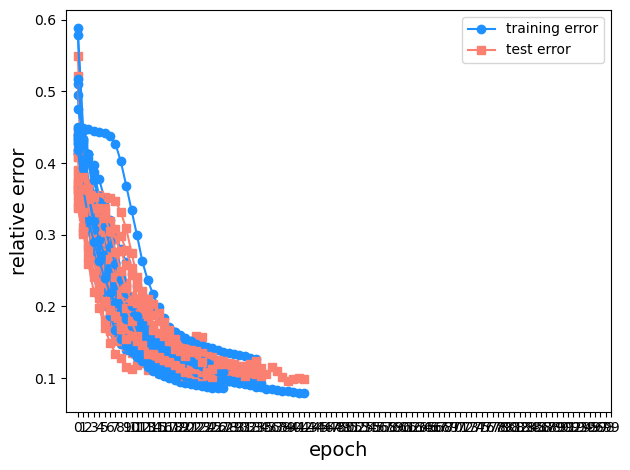

In [46]:
# plot the relative DAS training and test error for the last replica network
plot_errors(results_das)

### Get training results

In [47]:
# select the surrogate with the lowest test error
epoch_stop = results_das['epoch_stop']
test_errors = np.array(results_das['errors'])[:, :, 1]
test_errors = [error[epoch_stop[idx]] for idx, error in enumerate(test_errors)]
best_idx = np.argmin(test_errors)
das_surrogate = results_das['surrogate'][best_idx]

# compute the active subspace on the training and test data
W_1 = results_das['projection_matrix'][best_idx]
y_das_train = np.dot(W_1.T, params_train.T).T
y_das_test = np.dot(W_1.T, params_test.T).T

### Recreate the eigenvalue plots

Plot the eigenvalues with confidence intervals. The first eigenvalue should have a very small CI. If not, it's likely that one of the replica networks did not converge properly.

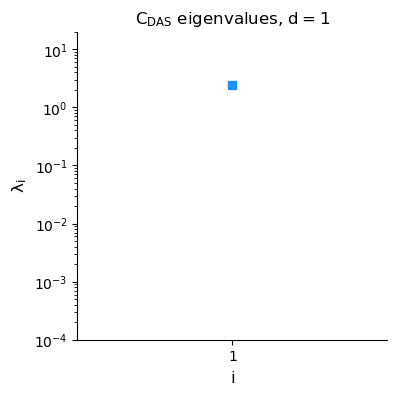

In [48]:
# number of eigenvalues to plot
n_vals = d

# basic analysisclass to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

# DAS eigenvalues
eigvals_C_das = results_das['eigvals']
# eigenvalues averaged over the n_rep replica networks
mean_eigval_das = np.mean(eigvals_C_das[:, 0:n_vals], axis=0)
# compute confidence intervals
lower, upper = analysis.get_confidence_intervals(eigvals_C_das[:, 0:n_vals])
y_err_das = np.array([mean_eigval_das - lower, upper - mean_eigval_das])

# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', title=r'%s eigenvalues, $d=%d$' % (r'$C_{DAS}$', d), ylim=[1e-4, 20])
ax1.set_ylabel(r'$\lambda_i$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
ax1.errorbar(range(1, n_vals + 1), mean_eigval_das, yerr = y_err_das, fmt='s', color='dodgerblue')
ax1.set_xticks(np.arange(1, n_vals + 1, 1))
sns.despine(top=True)


### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [49]:
# run the surrogates at a number of random inputs locations
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
das_samples_pred = np.zeros(n_mc)
for i in range(n_mc):
    das_samples_pred[i] = das_surrogate.predict(pred_inputs[i])


In [50]:
# active subspace at prediction inputs x
y_val_das = np.dot(W_1.T, pred_inputs.T).T


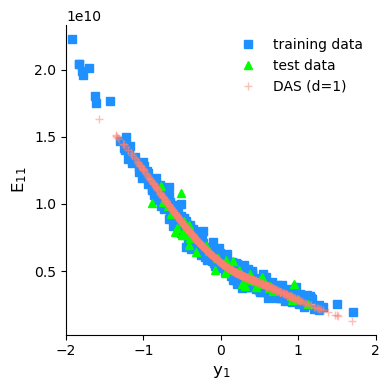

In [51]:
# QoI labels
lbl = {'E11': r'$E_{11}$', 'poisson': r'Poisson ratio', 'bulk': 'Bulk modulus'}

# plot DAS surrogate
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111,  xlim=[-2,2])    #E11 range
#ax = fig.add_subplot(111, ylim = [0.15, 0.45], xlim= [-2, 2]) # Poisson range
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_ylabel(lbl[QoI], fontsize=12)
ax.plot(y_das_train[:,0], samples_train, 's', color='dodgerblue', label='training data') 
ax.plot(y_das_test[:,0], samples_test, '^', color='lime', label='test data') 
ax.plot(y_val_das[:,0], das_samples_pred, '+', color='salmon', label='DAS (d=%d)' % d, alpha=0.5)
leg = ax.legend(loc=0, frameon=False)
leg.set_draggable(True)
sns.despine(top=True)
plt.tight_layout()
plt.savefig('./images/epoxy_surrogate_d1_%s.png' % (QoI, ))


### Recreate the global-derivative based sensitivity plots

In [52]:
def plot_sensitivity(results, n_include = 25, **kwargs):
    """
    Plot the global derivative-based sensitivity indices with confidenceintervals

    Parameters
    ----------
    results : dict
        dict containing the results for each of the n_rep replica networks
    n_include : int, optional
        How many indices to plot. The default is 25.

    Returns
    -------
    None.

    """     
    # the sensitivity indices
    V_i = results['V_i']
    # compute mean over replicas
    V_i_mean = np.mean(V_i, axis = 0)
    # rank indices according to mean
    idx = np.fliplr(np.argsort(np.abs(V_i_mean.reshape([-1, 1])).T))[0]

    # compute confidence interval
    analysis = es.analysis.BaseAnalysis()
    lower, upper = analysis.get_confidence_intervals(V_i)
    x_err = np.array([V_i_mean[idx] - lower[idx], upper[idx] - V_i_mean[idx]])
  
    # plot results
    fig = plt.figure(figsize=[4, 10])
    ax = fig.add_subplot(111, title=kwargs.get('title', ''))

    ax.set_xlabel(r'$\nu_i$', fontsize=14)    
    ax.barh(range(n_include), width = V_i_mean[idx].flatten()[0:n_include],
            xerr = x_err[:, 0:n_include], color = 'dodgerblue')
    ax.set_yticks(range(n_include))
    ax.set_yticklabels(param_names[idx][0:n_include], fontsize=14)
    ax.invert_yaxis()
    sns.despine(top=True)
    plt.tight_layout()
    plt.savefig('./images/epoxy_SA_d%d_%s' % (d, QoI))

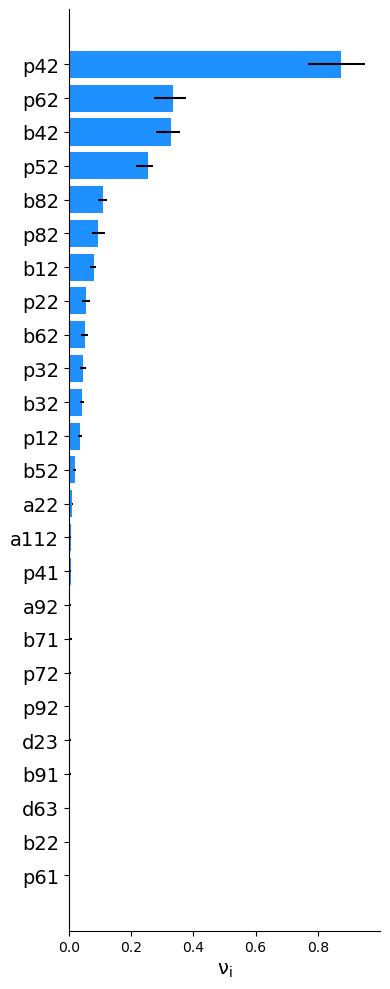

In [53]:
# plot sensitivity indices with CIs
plot_sensitivity(results_das)

### Compare epistemic with aleatoric uncertainty

Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate
done


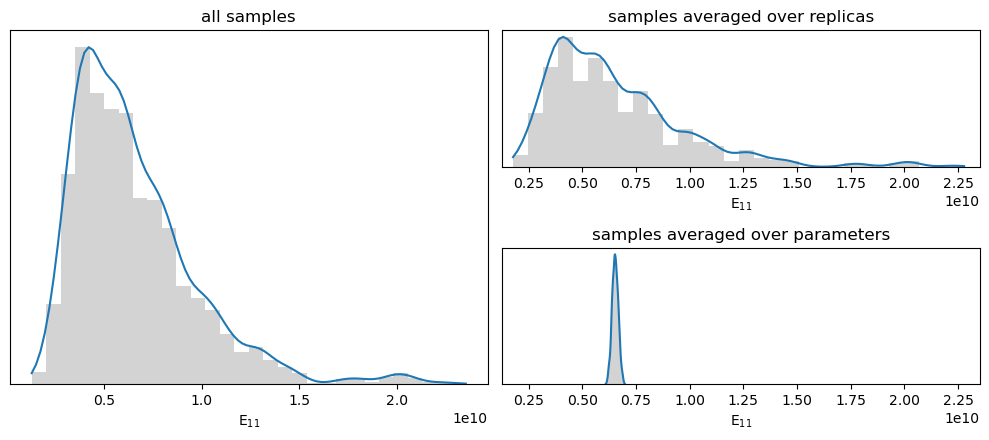

In [54]:
analysis = es.analysis.BaseAnalysis()

fig = plt.figure(figsize=[10,4.5])
ax1 = fig.add_subplot(1, 2, 1, title='all samples')
count, _, _ = ax1.hist(output.flatten(), 30, color='lightgray')
dom, kde = analysis.get_pdf(output)
# scale kde to match histogram
ax1.plot(dom, kde * np.max(count) / np.max(kde))
ax1.set_yticks([])
ax1.set_xlabel(lbl[QoI])

n_bootstrap = 1000
n_replicas = output.shape[1]
n_samples = output.shape[0]

output_replicas = np.zeros([n_bootstrap, n_replicas])
output_params = np.zeros([n_bootstrap, n_samples])

for i in range(n_bootstrap):
    
    idx = np.random.randint(0, n_samples - 1, n_samples)
    # average out parameters
    output_replicas[i] = np.mean(output[idx], axis=0)
    idx = np.random.randint(0, n_replicas - 1, n_replicas)
    # average out replicas
    output_params[i] = np.mean(output[:, idx], axis=1)

ax2 = fig.add_subplot(2, 2, 2, title='samples averaged over replicas',
                     xlim=[np.min(output), np.max(output)])

count, _, _ = ax2.hist(output_params.flatten(), 30, color='lightgray')
dom, kde = analysis.get_pdf(output_params.flatten())
# scale kde to match histogram
ax2.plot(dom, kde * np.max(count) / np.max(kde))
ax2.set_yticks([])
ax2.set_xlabel(lbl[QoI])

ax3 = fig.add_subplot(2, 2, 4, title='samples averaged over parameters',
                     xlim=[np.min(output), np.max(output)])
count, _, _ = ax3.hist(output_replicas.flatten(), 30, color='lightgray')
dom, kde = analysis.get_pdf(output_replicas.flatten())
# scale kde to match histogram
ax3.plot(dom, kde * np.max(count) / np.max(kde))
ax3.set_yticks([])
ax3.set_xlabel(lbl[QoI])

plt.tight_layout()
plt.savefig("./images/%s_dist" % (QoI))